In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.io import wavfile
from pydub import AudioSegment
import sounddevice as sd
import wave
import numpy as np
import torchaudio
import os
import pathlib
import torch
from torch.utils.data import TensorDataset, DataLoader
import pyaudio
from torchvision import transforms
from math import ceil

import matplotlib.pyplot as plt
import custommodels as cm

In [3]:
torch.cuda.is_available = lambda : False

In [4]:
OUTPUT_DEVICE = sd.default.device[1]
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE =  32000
CHUNK = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self,input_data,transform=None):
        self.input_data = input_data
        self.transform=transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        label = self.input_data[index][0]
        audiochunk = self.input_data[index][1]
        if self.transform:
            audiochunk = self.transform(audiochunk)
        return audiochunk,label

In [6]:
def make_chunks_torch(audio_segment, chunk_length):
    """
    Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
    long.
    if chunk_length is 50 then you'll get a list of 50 millisecond long audio
    segments back (except the last one, which can be shorter)
    """
    number_of_chunks = ceil(audio_segment.shape[1] / float(chunk_length))
    for i in range(int(number_of_chunks)):
        yield audio_segment[0,i * chunk_length:(i + 1) * chunk_length]

In [145]:
audio_data = []
folder_labels = dict()
i=0

folder = 'Audio' #Assume this is where all audio folders are located. This folder is at same level as script.
abspath = folder
subfolders = os.listdir(abspath)

for audiogroup in subfolders:
    print("Folder:",audiogroup)
    files = os.listdir(os.path.join(abspath,audiogroup))
    folder_labels[audiogroup] = i
    #print("\tFiles:",files)
    for file in files:
        relpath = os.path.join(os.path.join(abspath,audiogroup),file)
        #print(f"\t\tLoading {relpath}")
        data,samplerate = torchaudio.load(relpath,normalize=False)
        if samplerate!=RATE:
            data = torchaudio.transforms.Resample(samplerate,RATE)(data)
        data = torch.mean(data,dim=0).unsqueeze(0)
        #data = data / torch.max(data)
        #data = (data - torch.mean(data)) / torch.std(data) 
        #data = torch.nn.functional.normalize(data)
        #print(data.shape)
        for chunk in make_chunks_torch(data,CHUNK):
            torchdatachunk = torch.cat([chunk,torch.zeros(CHUNK-len(chunk))])
            torchdatachunk = torch.reshape(torchdatachunk,(1,-1))
            audio_data.append((i,torchdatachunk))
        #torchdatachunk = torch.reshape(data,(1,-1))
        #audio_data.append((i,torchdatachunk))
    i+=1

batch_size = 100
train_ds = AudioDataset(audio_data[0:10])
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

Folder: 0-Ekko
Folder: 1-Kindred


In [20]:
def playAudio(audioflat):
    def make_chunks(audio_segment, chunk_length):
        """
        Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
        long.
        if chunk_length is 50 then you'll get a list of 50 millisecond long audio
        segments back (except the last one, which can be shorter)
        """
        number_of_chunks = ceil(len(audio_segment) / float(chunk_length))
        for i in range(int(number_of_chunks)):
            yield audio_segment[i * chunk_length:(i + 1) * chunk_length]
    p = pyaudio.PyAudio()
    outputstream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    output_device_index=OUTPUT_DEVICE,
                    output=True,start=False)

    outputstream.start_stream()


    seg = AudioSegment(
        audioflat.tobytes(), 
        frame_rate=RATE,
        sample_width=pyaudio.get_sample_size(FORMAT), 
        channels=CHANNELS
    )
    for chunk in make_chunks(seg,CHUNK):
        outputstream.write(chunk._data)

    outputstream.stop_stream()

In [37]:
def convAudio(audiobit):
    return (audiobit.numpy()*1000).astype(np.int16).flatten()

In [50]:
playAudio(convAudio(audio_data[54][1][0]))

## Run Models

In [81]:
import auraloss

In [146]:
def loss_function(recon_x, x, mu, logvar):
    #print(torch.min(recon_x),torch.max(recon_x))
    #print(torch.min(x),torch.max(x))
    #print(recon_x.shape,x.shape)
    bce = torch.nn.MSELoss() #torch.nn.BCELoss()
    BCE = bce(recon_x,x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * .0001 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(BCE,KLD)

    return BCE + KLD

In [107]:
import custommodels as cm
import math
model = cm.SimpleRNN(CHUNK,skip=0).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)
model.train()
loss_func = auraloss.time.ESRLoss()


for label,sample in audio_data:
    ep_loss = 0
    optimizer.zero_grad()
    model.zero_grad()


    batch_loss = 0
    start_i = 0
    up_fr = CHUNK
    # Iterate over the remaining samples in the mini batch
  
    for k in range(math.ceil((sample.shape[-1])-200)//up_fr):
        audsample = sample[:,start_i:start_i + up_fr].to(device)

        output = model(audsample)
        # Calculate loss and update network parameters
        loss = loss_func(output, audsample)
        loss.backward()
        optimizer.step()

        # Set the network hidden state, to detach it from the computation graph
        model.detach_hidden()
        model.zero_grad()

        # Update the start index for the next iteration and add the loss to the batch_loss total
        start_i += up_fr
        batch_loss += loss

    # Add the average batch loss to the epoch loss and reset the hidden states to zeros
    ep_loss += batch_loss / (k + 1)
    print(ep_loss)
    model.reset_hidden()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


train
2 iterations
recon_error: 0.037561930716038



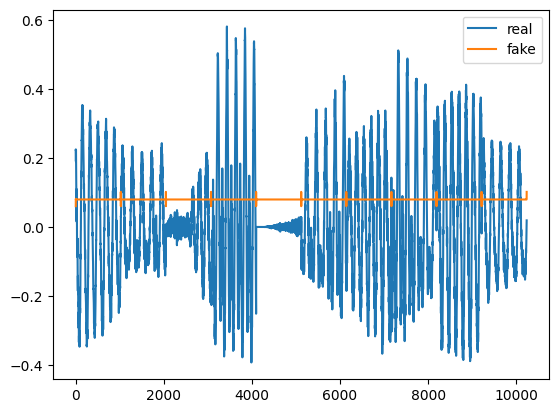

In [213]:
import custommodels as cm
model = cm.WaveNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)
model.train()
mrstft = torch.nn.MSELoss() #auraloss.time.ESRLoss()

i=0
max_epochs = 1
for epoch in range(max_epochs):
    for real_audio,labels in train_loader:
        real_audio = real_audio.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        #print(real_audio.shape)
        x_recon = model(real_audio,labels) # vq_loss,perplexity
        #print(x_recon.shape)

        recon_error = torch.nn.MSELoss()(x_recon, real_audio) #/ data_variance
        loss = recon_error #+ .5*vq_loss
        loss.backward()

        #loss = mrstft(x_recon,real_audio) 
        #loss.backward()
      
        optimizer.step()
        #print(loss.item())
        i+=1
    if epoch%4==0:
        print('%d iterations' % (i+1))
        print('recon_error: %.15f' % loss.item())
        print()
        flatreal = real_audio.detach().cpu().numpy().flatten()
        fakereal = x_recon.detach().cpu().numpy().flatten()
        plt.plot(flatreal,label='real')
        plt.plot(fakereal,label='fake')
        plt.legend()
        plt.show()

In [14]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

5138095616
5536481280


In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Check Audio Output

In [75]:
def make_chunks(audio_segment, chunk_length):
    """
    Breaks an AudioSegment into chunks that are <chunk_length> milliseconds
    long.
    if chunk_length is 50 then you'll get a list of 50 millisecond long audio
    segments back (except the last one, which can be shorter)
    """
    number_of_chunks = ceil(len(audio_segment) / float(chunk_length))
    for i in range(int(number_of_chunks)):
        yield audio_segment[i * chunk_length:(i + 1) * chunk_length]

In [163]:
testdata = []
abspath = 'Audio'
audiogroup = "1-Kindred"
print("Folder:",audiogroup)
files = os.listdir(os.path.join(abspath,audiogroup))
i = folder_labels[audiogroup]
file = "Kindred.mark05.wav"

relpath = os.path.join(os.path.join(abspath,audiogroup),file)
#print(f"\t\tLoading {relpath}")
data,samplerate = torchaudio.load(relpath,normalize=False)
if samplerate!=RATE:
    data = torchaudio.transforms.Resample(samplerate,RATE)(data)
data = torch.mean(data,dim=0).unsqueeze(0)
#data = (data - torch.mean(data)) / torch.std(data) 
#data = torch.nn.functional.normalize(data)

for chunk in make_chunks_torch(data,CHUNK):
    torchdatachunk = torch.cat([chunk,torch.zeros(CHUNK-len(chunk))])
    torchdatachunk = torch.reshape(torchdatachunk,(1,-1))
    testdata.append((0,torchdatachunk))

batch_size = 200
test_ds = AudioDataset(testdata)
test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle=False)

Folder: 1-Kindred


### Actual Audio:

In [158]:
fullaudio = []
for audiochunk in testdata:
    fullaudio += list(audiochunk[1].detach().cpu().numpy())
fullaudio = (np.array(fullaudio)*1000).astype(np.int16).flatten()

In [159]:
playAudio(fullaudio)

### Reconstructed Audio:

In [164]:
reconaudio = []
with torch.no_grad():
    for true_audio,labels in test_loader:
        true_audio = true_audio.to(device)
        labels = labels.to(device)
        recon  = model(true_audio,labels)
        reconaudio += list(recon.detach().cpu().numpy())
    reconaudio = (np.array(reconaudio)*1000).astype(np.int16).flatten()

In [165]:
playAudio(reconaudio)

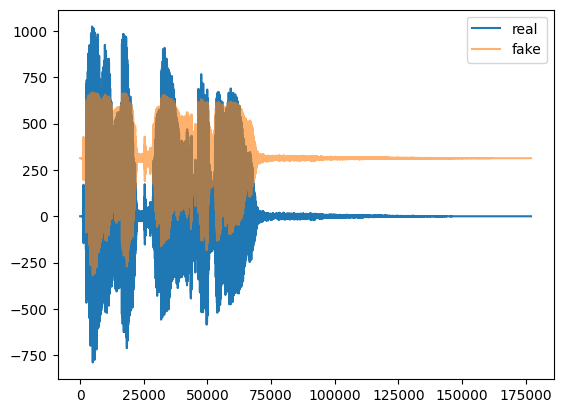

In [156]:
plt.plot(fullaudio,label='real')
plt.plot(reconaudio,label='fake',alpha=.6)
plt.legend()

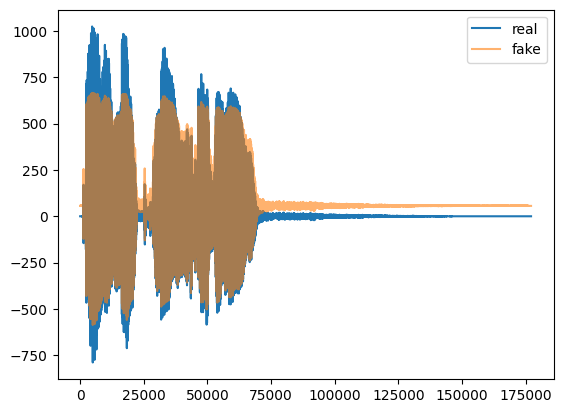

In [162]:
plt.plot(fullaudio,label='real')
plt.plot(reconaudio,label='fake',alpha=.6)
plt.legend()